In this notebook, we train a Neural Network classificatory model to classify stars following the Harvard classification based on effective temperature.

# Setup

In [13]:
# --- Core Data & Math Libraries ---
import numpy as np
import pandas as pd
from pathlib import Path

# --- Scikit-Learn Components ---
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Imbalanced Learning (if you're using SMOTE later) ---
#from imblearn.over_sampling import SMOTE

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- TensorFlow ---
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


# --- Path Configuration ---
notebook_path = Path().absolute()    # Current notebook location
project_root = notebook_path.parent  # Project root directory

We start by reading our data from the Gold layer.

In [5]:
# reading the data from the gold layer
dfG = pd.read_csv(project_root/'data'/'gold'/'starG.csv')
dfG

,identifier,class,full_class,harvard_classification,harvard_subclass,effective_temperature,log_surface_gravity,metallicity_fe_h,radial_velocity,redshift
0,300702165|2015/01/19,K,K4,K,K1,4729.36,4.741,-0.128,42.15,0.000141
1,215109|2011/10/23,G,G8,K,K2,4642.57,4.662,-0.363,36.61,0.000122
2,18112111|2011/12/18,K,K3,K,K2,4664.49,4.690,-0.207,35.04,0.000117
3,367412199|2015/10/07,G,G9,K,K0,4960.44,4.613,-0.262,-35.46,-0.000118
4,18112179|2011/12/18,G,G8,G,G9,5371.04,4.296,-0.248,-29.91,-0.000100
...,...,...,...,...,...,...,...,...,...,...
995,483006085|2016/11/22,G,G8,K,K0,5163.64,4.631,-0.220,18.72,0.000062
996,482906085|2016/11/22,G,G0,K,K0,5277.30,3.014,-1.450,-41.81,-0.000139
997,211126|2011/10/23,G,G6,G,G9,5374.96,4.349,-0.430,-46.33,-0.000155
998,300014028|2015/01/18,G,G5,K,K4,4411.23,2.331,-0.181,19.43,0.000065


# 1. Neural Network Model

We now proceed to train the classifying model using Neural Network.

In [8]:
# === CONFIGURATION ===
TARGET_COLUMN = ['harvard_classification']
FEATURE_COLUMNS = ['effective_temperature']

# Set global random seed
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# === Hyperparameters (Change these!) ===
NUM_HIDDEN_LAYERS = 30           #  Number of hidden layers
NEURONS_PER_LAYER = 3         #  Neurons in each hidden layer
ACTIVATION_FUNCTION = 'relu'    #  Activation function for hidden layers
EPOCHS = 50
BATCH_SIZE = 16

# === Data Preparation ===
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dfG[TARGET_COLUMN].values.ravel())
X = dfG[FEATURE_COLUMNS].values
num_classes = len(label_encoder.classes_)
y_cat = to_categorical(y, num_classes)



X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.3, stratify=y, random_state=42
)

# === Model Builder Function ===
def build_model(input_dim, num_classes, num_layers, units, activation):
    model = Sequential()
    model.add(Dense(units, activation=activation, input_shape=(input_dim,)))
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# === Build and Compile Model ===
model = build_model(
    input_dim=X_train.shape[1],
    num_classes=num_classes,
    num_layers=NUM_HIDDEN_LAYERS,
    units=NEURONS_PER_LAYER,
    activation=ACTIVATION_FUNCTION
)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Train Model ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0
)

# === Evaluate Model ===
y_pred_prob = model.predict(X_val)
y_pred = y_pred_prob.argmax(axis=1)
y_val_classes = y_val.argmax(axis=1)

print("\n=== Neural Network Evaluation ===")
print(f"Validation Accuracy: {accuracy_score(y_val_classes, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(
    y_val_classes, y_pred,
    target_names=label_encoder.classes_,
    zero_division=0
))

# === Reusable model function ===
def class_classifier():
    return model



C:\Users\natha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

=== Neural Network Evaluation ===
Validation Accuracy: 0.4500

Classification Report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
           F       0.00      0.00      0.00        47
           G       0.45      1.00      0.62       135
           K       0.00      0.00      0.00       116
           M       0.00      0.00      0.00         1

    accuracy                           0.45       300
   macro avg       0.09      0.20      0.12       300
weighted avg       0.20      0.45      0.28       300



The above results can be better visualized in Confusion Matrix Form.

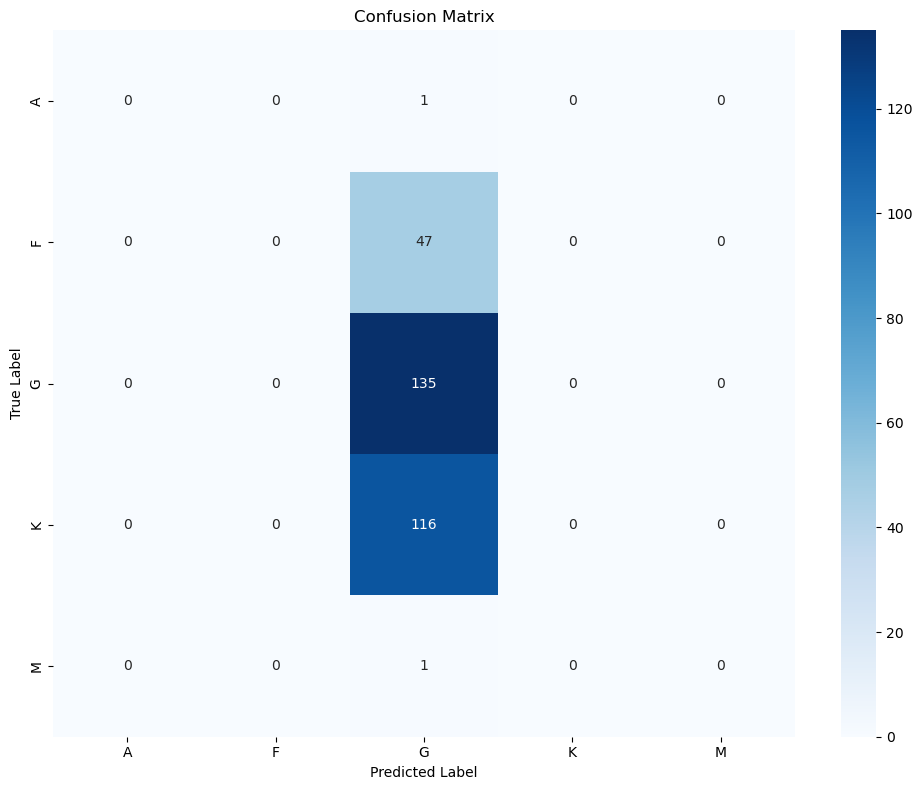

In [10]:
# Generate and plot confusion matrix
# Convert one-hot encoded true labels back to class indices
y_val_classes = y_val.argmax(axis=1)
y_pred_classes = y_pred_prob.argmax(axis=1)  # from previous cell

# Compute confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


To test the consistency of the above results, we also perform cross-validation of our Neural Network.

In [12]:

# Convert labels to integer class indices (not one-hot) for stratification
y_labels = label_encoder.transform(dfG[TARGET_COLUMN].values.ravel())

# Prepare data
X_values = dfG[FEATURE_COLUMNS].values
num_classes = len(label_encoder.classes_)

# Cross-validation configuration
NUM_FOLDS = 5
RANDOM_STATE = 42
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_STATE)

fold_accuracies = []

for fold, (train_index, val_index) in enumerate(skf.split(X_values, y_labels)):
    print(f"\n=== Fold {fold+1} ===")
    
    # Split data
    X_train, X_val = X_values[train_index], X_values[val_index]
    y_train, y_val = y_labels[train_index], y_labels[val_index]

    # One-hot encode targets
    y_train_cat = to_categorical(y_train, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)

    # Build new model
    model = build_model(
        input_dim=X_train.shape[1],
        num_classes=num_classes,
        num_layers=NUM_HIDDEN_LAYERS,
        units=NEURONS_PER_LAYER,
        activation=ACTIVATION_FUNCTION
    )

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    model.fit(X_train, y_train_cat,
              validation_data=(X_val, y_val_cat),
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              verbose=0)

    # Evaluate
    y_val_pred = model.predict(X_val).argmax(axis=1)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    fold_accuracies.append(acc)

# Overall results
print("\n=== Cross-Validation Results ===")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies):.4f}")


C:\Users\natha\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\natha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Fold 1 ===
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
Validation Accuracy: 0.4500

=== Fold 2 ===


C:\Users\natha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

KeyboardInterrupt

